In [1]:
%%time
import pickle
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.data.build_graph import build_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train import train_model
from utils.evaluation.evaluate_model import evaluate_model


CPU times: user 1.73 s, sys: 1.15 s, total: 2.88 s
Wall time: 1.51 s


In [2]:
%%time
load_root = False

if load_root:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    # path = 'root2pandas/data/evtcomplete_small'
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 113 ms, sys: 109 ms, total: 221 ms
Wall time: 220 ms


In [3]:
nevents = raw.index.max()
raw

,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id
event_id,,,,,,,,,
0,0,-15.907500,606.994995,0.453287,2.604892,5,0,5,33
0,1,-15.402500,607.869690,0.168081,2.604809,5,0,5,34
0,2,-15.967299,611.489990,0.338337,2.604617,5,1,5,35
0,3,-15.460370,612.364685,0.275247,2.604552,5,1,5,36
0,4,-16.981157,616.489990,0.066004,2.604429,5,1,5,37
...,...,...,...,...,...,...,...,...,...
29999,236,5.683260,644.364685,0.086834,7.105113,6,1,0,44
29999,237,4.457249,648.489990,0.159684,7.105056,6,1,0,45
29999,238,3.950320,649.364685,0.385276,7.104989,6,1,0,46


In [4]:
show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

In [5]:
%%time
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)

CPU times: user 2.09 s, sys: 482 ms, total: 2.57 s
Wall time: 2.34 s


In [6]:
data.events.sort_index()

,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,6116267,15.907500,423.839691,0.089051,5.259365,3,0,4,24,45,12,424.138105,0.037514
0,6365503,31.562500,466.964996,0.401660,2.415465,4,0,0,31,227,15,468.030447,0.067488
0,5305347,-16.917500,621.489990,0.377410,2.604239,5,0,5,39,6,19,621.720202,-0.027214
0,3306830,-19.442499,639.869690,0.217349,2.603750,6,0,5,42,9,22,640.165003,-0.030376
0,2546672,67.417503,622.364685,0.432113,7.615374,5,0,2,40,139,20,626.005528,0.107904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29999,2132188,3.787500,467.839691,0.173896,1.370869,4,0,5,32,31,16,467.855022,0.008096
29999,373099,-12.372500,342.264679,0.075568,1.087071,2,0,1,16,159,8,342.488232,-0.036133
29999,1841629,-20.452499,342.264679,0.006372,6.254503,2,0,4,16,64,8,342.875218,-0.059685


In [7]:
graphs = data.create_graph_list()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29999/29999 [02:58<00:00, 167.74it/s]


In [8]:
# purity, efficiency, bad_graphs = evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()
purity, efficiency, bad_graphs = evaluate_graphs(data.events, graphs).evaluate_graphs()
print(np.mean(purity),np.mean(efficiency))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29999/29999 [02:07<00:00, 234.77it/s]

0.5283159836418047 0.990664219238505


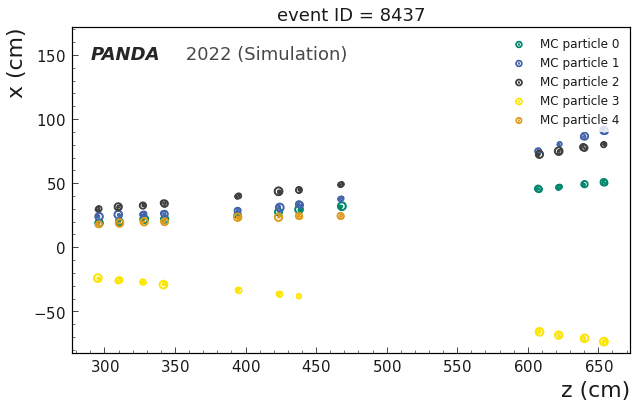

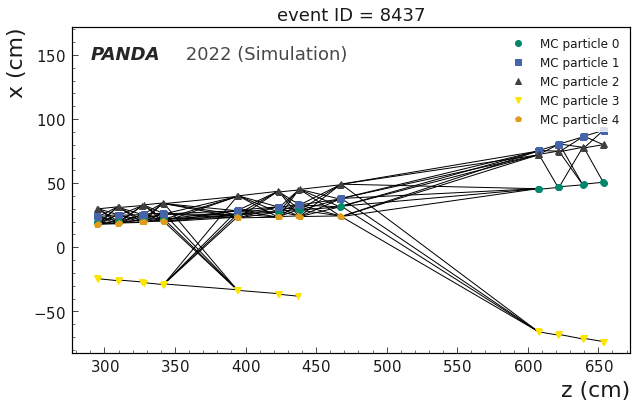

In [9]:
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



In [10]:
torch.manual_seed(42)
device = torch.device('cpu')
hidden_size = 8
lr = 0.01
gamma = 0.7
epochs = 30
patience = 5
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **params)

In [11]:
model = InteractionNetwork(node_indim=4, edge_indim=4, node_outdim=4, edge_outdim=4, hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
patience = 3
model.count_parameters()

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     96     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     32     |
|  R1.layers.4.bias  |     4      |
| O.layers.0.weight  |     64     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     32     |
|  O.layers.4.bias   |     4      |
| R2.layers.0.weight |     96     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 577
InteractionNetwork()


In [ ]:
results = train_model(train_loader, val_loader, test_loader, model, optimizer, scheduler, epochs=epochs, patience=patience)

  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]

In [ ]:
model, losses, accs, disc, test_losses, test_accs = results.trained

In [ ]:
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, disc, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

In [ ]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)